In [6]:
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!find data -type f -name '*.csv'

data/swpc/kpindices-2022.csv
data/swpc/kpindices-2023.csv
data/dscovr/dsc_fc_summed_spectra_2023_v01.csv
data/dscovr/dsc_fc_summed_spectra_2022_v01.csv


In [3]:
x_df = pd.read_csv("./data/dscovr/dsc_fc_summed_spectra_2022_v01.csv", delimiter = ',', parse_dates=[0], infer_datetime_format=True, na_values='0', header = None)
y_df = pd.read_csv("./data/swpc/kpindices-2022.csv", delimiter = ',', parse_dates=[0], infer_datetime_format=True, na_values='0', header = 0)

In [4]:
x_df.describe()

,1,2,3,4,5,6,7,8,9,10,...,44,45,46,47,48,49,50,51,52,53
count,524450.000000,524450.000000,524450.000000,511816.000000,511811.000000,511809.000000,511809.000000,511815.000000,511815.000000,511814.000000,...,20115.000000,11191.000000,8416.000000,3971.000000,3859.000000,213.000000,139.000000,44.000000,40.000000,35.000000
mean,0.098939,-0.219225,0.060599,58.218162,9.514369,63.246343,56.563212,74.062121,65.428809,94.261894,...,384.711976,332.966637,388.589832,326.915073,294.150454,390.130451,384.123885,376.326977,403.068593,367.789749
std,3.943064,4.535931,3.667523,38.506281,17.031107,44.696797,45.047853,60.528255,82.509457,114.361904,...,40.774888,48.215582,38.280578,57.801942,85.771695,52.754546,51.583450,69.893480,124.156716,143.007012
min,-16.712300,-26.376500,-23.060000,0.231726,0.231726,0.231726,0.231726,0.231726,0.231726,0.231726,...,214.319000,188.544000,211.826000,205.870000,108.950000,202.247000,112.290000,187.778000,0.231726,89.996200
25%,-3.000140,-3.305092,-1.967988,28.843000,0.231726,32.352500,27.916000,37.301550,25.640400,36.973425,...,365.230000,302.532500,367.203750,274.956000,211.853000,359.223000,352.946500,354.073000,366.691750,241.622000
50%,0.212469,-0.288369,0.034746,51.989300,0.386813,55.570600,46.977600,61.355300,45.470200,68.838050,...,383.495000,326.713000,393.807500,323.581000,309.980000,389.128000,395.347000,383.129500,427.067000,403.663000
75%,3.164427,3.017987,2.039108,84.737900,15.812800,90.033900,80.592700,100.403000,84.142500,114.472000,...,404.069000,363.782500,409.080750,377.611000,367.034500,416.967000,410.484000,411.971250,471.866000,449.118500
max,19.725300,22.834700,27.905900,415.389000,385.676000,493.748000,746.807000,1136.670000,1562.550000,1804.560000,...,662.013000,735.132000,772.122000,521.745000,541.136000,637.731000,568.053000,528.470000,655.892000,646.111000


In [17]:
y_df.head()

,date,3,6,9,12,15,18,21,24
0,2022-11-22,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
1,2022-11-29,4.0,3.0,4.0,4.0,4.0,5.0,4.0,3.0
2,2022-11-07,1.0,1.0,2.0,3.0,4.0,5.0,4.0,3.0
3,2022-11-05,3.0,3.0,2.0,3.0,2.0,2.0,1.0,1.0
4,2022-11-04,4.0,4.0,3.0,3.0,3.0,3.0,2.0,2.0


We can see that the timestamp is different between data sources and we will need to fix that. Because we want to train on a relative measure of time we will convert the data into training examples with an integer ordinal number.

What other changes will be needed?

- convert date and time to an ordinal count of seconds since the start time of one example
- convert the kp indices to an integer
- transform dscovr NaNs into 0 (for now - maybe there is a better value to use)
- filter kp rows that have invalid data (-1s)
- normalize dscovr mag field values
- normalize dscovr solar wind values

The last transform we need to make is to organize the data from dscovr into training examples having a shape of (4320, 53, 2). In axis 0 we have 4,320 minutes per 3 days.
In axis 1 we have the 53 data points for each minute.
In axis 2 we have the ISO date timestamp of the Kp index we are learning and the Kp index we want to learn to predict.

Note that we will generate a new training example for every 3 hour Kp index for each day so we want to cache the pr with evious data and shift it for efficiency.

We need to save our training set to files with random training/valid/test splits. We will split 10% of the examples for validation and save them as 'valid.h5' and the remaining 90% will be our training examples stored as 'train.h5'.which is

We still don't have a held-out test set for evaluating the performance of our model. We will use the 2022 data for training and validation sets and the 2023 data as our test set. Of course, you could come back and change this by combining 2022 and 2023 into one big set then splitting it 3 ways, maybe with an 80/10/10 split which is commonly used.



First we will remove any rows where the timestamp is missing

In [13]:
x_df.head()

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,2022-01-01 00:00:00,-6.17170,1.124830,-4.90228,38.0314,0.231726,46.0427,44.9743,55.9143,43.7069,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-01-01 00:01:00,-6.28883,1.233130,-4.79001,38.3868,0.231726,45.5257,46.2587,55.1428,43.2768,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-01-01 00:02:00,-6.11811,0.871923,-5.12830,37.5636,0.231726,45.1955,46.8222,55.7484,42.7894,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-01-01 00:03:00,-6.28704,1.249870,-4.76640,38.1094,0.242084,46.7083,47.1713,53.5380,42.1558,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-01-01 00:04:00,-6.42125,1.171560,-4.53230,37.5893,0.231726,47.4888,45.3234,54.5404,44.2773,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
x_df.fillna(0, inplace=True) # this seems like a better alternative to dropping stuff for now

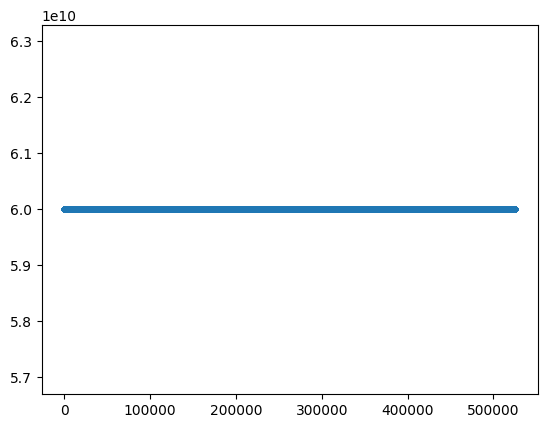

In [7]:
x_diff = x_df[0].diff()[1:]
plt.plot(x_diff,'.')

In [27]:
x_df[1].isnull().sum()

1150

In [29]:
x_df.shape

(525600, 54)

In [30]:
x_df[x_df[1].isna()]

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
11351,2022-01-08 21:11:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11352,2022-01-08 21:12:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11353,2022-01-08 21:13:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11354,2022-01-08 21:14:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11355,2022-01-08 21:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
470150,2022-11-23 11:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
470151,2022-11-23 11:51:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
470152,2022-11-23 11:52:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
470153,2022-11-23 11:53:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Looks like these are rows that are empty for one reason or another

In [31]:
x_df = x_df.drop(x_df[x_df[1].isna()].index)
print(x_df.shape)

(524450, 54)


Now we will remove any rows where all of the solar wind values are missing (NaN)

In [9]:
x_df.loc[:,4:].isnull()

,4,5,6,7,8,9,10,11,12,13,...,44,45,46,47,48,49,50,51,52,53
0,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
1,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
2,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
3,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
4,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525595,False,False,False,False,False,False,False,False,False,False,...,False,True,True,True,True,True,True,True,True,True
525596,False,False,False,False,False,False,False,False,False,False,...,False,False,True,True,True,True,True,True,True,True
525597,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
525598,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True


In [34]:
x_df = x_df.drop(x_df[x_df.loc[:,4:].isnull().all(1)].index)
print(x_df.shape)

(511911, 54)


Now let's replace any remaining NaNs with 0

1 NaN == all NaN?

In [35]:
print(x_df.shape)
values = {}
for i in range(4, 54):
  values[i] = 0
print(values)
x_df = x_df.fillna(values)
print(x_df.shape)

(511911, 54)
{4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0}
(511911, 54)


In [14]:
x_df.describe()

,1,2,3,4,5,6,7,8,9,10,...,44,45,46,47,48,49,50,51,52,53
count,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,...,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000
mean,0.098723,-0.218745,0.060467,56.691375,9.264761,61.586849,55.079074,72.119681,63.712797,91.789492,...,14.723138,7.089478,6.222169,2.469901,2.159678,0.158101,0.101585,0.031504,0.030675,0.024491
std,3.938751,4.530978,3.663510,39.120382,16.874878,45.250273,45.363068,60.890642,82.088932,113.853171,...,74.236328,48.577743,49.016551,28.750389,26.165004,7.923232,6.301564,3.500630,3.675185,3.214034
min,-16.712300,-26.376500,-23.060000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-2.994410,-3.299317,-1.961993,27.144450,0.231726,30.528775,26.074075,35.494075,23.211725,34.756100,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.196711,-0.272798,0.027527,50.140600,0.304644,53.698500,45.975250,59.174000,44.476650,65.875650,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.159327,3.011640,2.033550,84.127150,15.305025,89.087500,79.370875,99.271750,82.563750,113.154250,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,19.725300,22.834700,27.905900,415.389000,385.676000,493.748000,746.807000,1136.670000,1562.550000,1804.560000,...,662.013000,735.132000,772.122000,521.745000,541.136000,637.731000,568.053000,528.470000,655.892000,646.111000


In [15]:
x_df.shape

(525600, 54)

In [16]:
M = y_df.shape[0]*(y_df.shape[1]-1)
print(M, 'Kp indices')
print(4320*x_df.shape[1], 'DSCOVR data points for each Kp index') # where did 4320 come from?

2920 Kp indices
233280 DSCOVR data points for each Kp index


In [17]:
x_M = int(x_df.shape[0] / 4320)
print(y_df.shape)

(365, 9)


In [44]:
import matplotlib.pyplot as plt
%matplotlib inline

In [48]:
x_df[0][0]

Timestamp('2022-01-01 00:00:00')

In [54]:
x_df[0][1]-x_df[0][0]

Timedelta('0 days 00:01:00')

In [177]:
#B = x_df[0][1:]-x_df[0][:-1]
x_diff = x_df[0].diff()[1:]

In [178]:
x_diff

1        0 days 00:01:00
2        0 days 00:01:00
3        0 days 00:01:00
4        0 days 00:01:00
5        0 days 00:01:00
               ...      
525595   0 days 00:01:00
525596   0 days 00:01:00
525597   0 days 00:01:00
525598   0 days 00:01:00
525599   0 days 00:01:00
Name: 0, Length: 511910, dtype: timedelta64[ns]

In [179]:
all(x_diff==x_diff[1])

False

In [181]:
x_diff[x_diff!=x_diff[1]]

490      0 days 00:55:00
1342     0 days 01:13:00
1932     0 days 00:58:00
2761     0 days 00:52:00
3375     0 days 01:01:00
               ...      
523220   0 days 00:04:00
524063   0 days 01:17:00
524665   0 days 01:12:00
524888   0 days 00:17:00
525505   0 days 01:18:00
Name: 0, Length: 257, dtype: timedelta64[ns]

In [ ]:
x_df[0].diff()[1:]==x_df[0].diff()[1:][1]

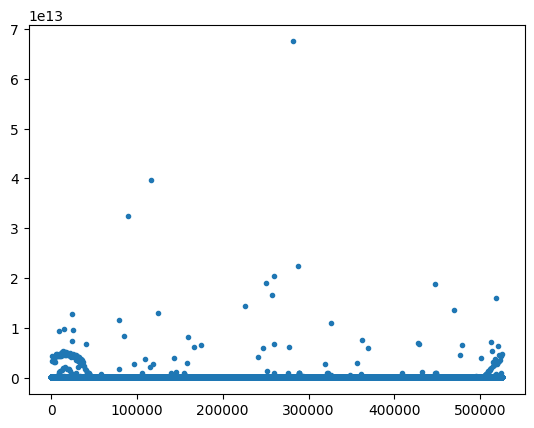

In [182]:
plt.plot(x_diff,'.')

In [78]:
import seaborn as sns

<Axes: xlabel='0'>

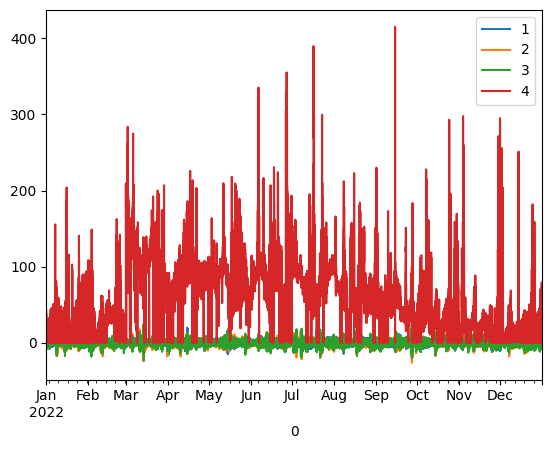

In [18]:
# sns.pointplot(data=x_df.loc[:,0:4])
x_df.plot(x=0,y=[1,2,3,4])

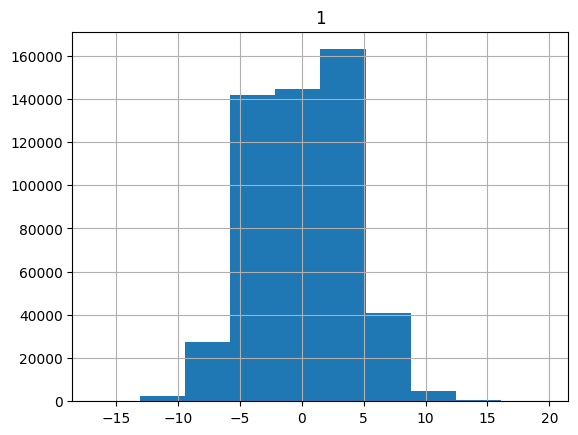

False


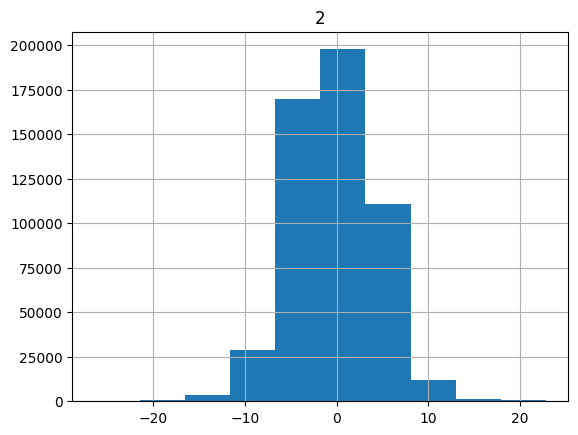

False


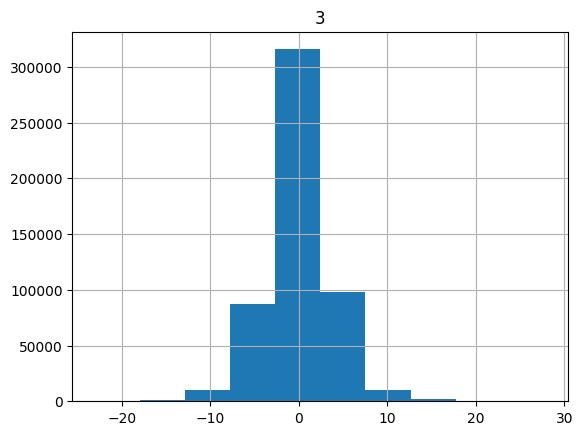

False


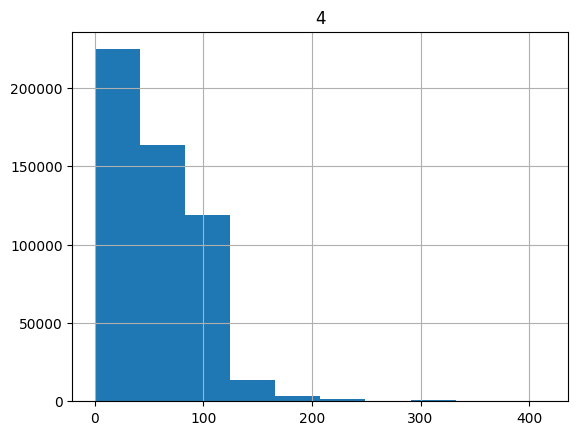

False


In [20]:
for i in range(1,5):
  x_df[i].hist()
  plt.title(i)
  plt.show()
  print(np.any(np.isnan(x_df[i])))


<Axes: xlabel='0'>

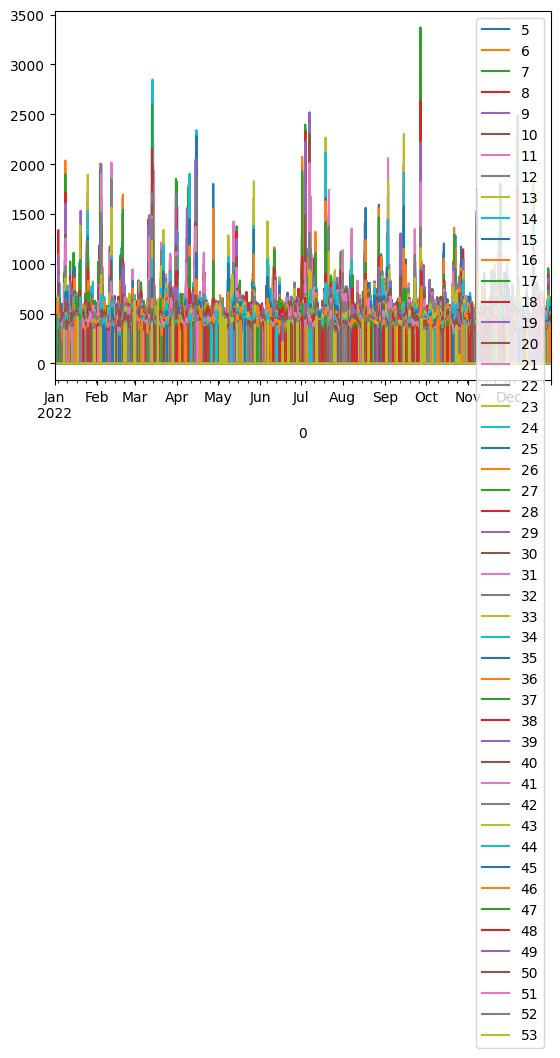

In [21]:
cols = list(np.arange(5,54))
x_df.plot(x=0,y=cols)

4
False
5
False
6
False
7
False
8
False
9
False
10
False
11
False
12
False
13
False
14
False
15
False
16
False
17
False
18
False
19
False
20
False
21
False
22
False
23
False
24
False
25
False
26
False
27
False
28
False
29
False
30
False
31
False
32
False
33
False
34
False
35
False
36
False
37
False
38
False
39
False
40
False
41
False
42
False
43
False
44
False
45
False
46
False
47
False
48
False
49
False
50
False
51
False
52
False
53
False


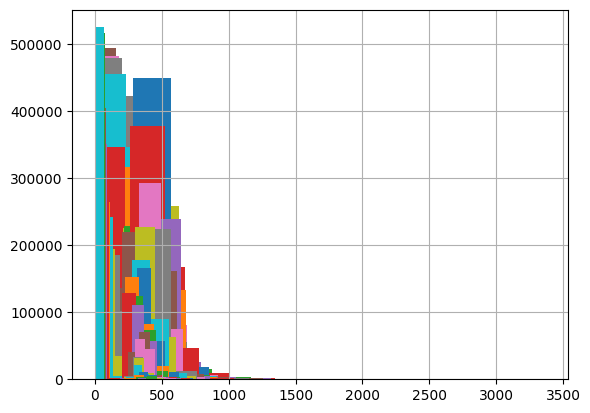

In [22]:
for i in range(4,54):
  x_df[i].hist()
  print(i)
  print(np.any(np.isnan(x_df[i])))


In [23]:
from sklearn.model_selection import train_test_split

train_ydf, valid_ydf = train_test_split(y_df, test_size=0.1)

In [24]:
train_ydf.head()

,date,3,6,9,12,15,18,21,24
264,2022-03-07,3.0,3.0,1.0,2.0,3.0,2.0,2.0,2.0
244,2022-03-16,1.0,NaN,1.0,2.0,2.0,2.0,2.0,2.0
201,2022-04-18,2.0,2.0,2.0,2.0,1.0,2.0,3.0,1.0
4,2022-11-04,4.0,4.0,3.0,3.0,3.0,3.0,2.0,2.0
94,2022-02-17,2.0,2.0,1.0,1.0,1.0,NaN,1.0,1.0


In [25]:
train_ydf.shape

(328, 9)

In [26]:
train_M = train_ydf.shape[0] * (train_ydf.shape[1]-1)
valid_M = valid_ydf.shape[0] * (valid_ydf.shape[1]-1)
print(train_M, ' training examples and ', valid_M, ' validation examples')

2624  training examples and  296  validation examples


**Problem** Each `y` corresponds to a single day whereas each `x` corresponds to roughly 1 minute. We need to *expand* each `y` to match uo with all the `x` or *compress* the appropriate collection of `x`'s into each `y`.

Notionally, let's say we'd like to consider 3 days prior to each day to make the prediction for the day.

In [27]:
from datetime import timedelta
def get_X(t, indf):
  match = indf.loc[:,0]==t #this means we have the exact time stamp in indf
  if indf[match].shape[0] == 1:
    x_idx = indf[match].index[0]
  else:
    x_idx = -1
    for h in range(24):
      nt = pd.to_datetime(t) - timedelta(hours=h) # subtract hours until find new mathc
      match = indf.loc[:,0]==nt
      if indf[match].shape[0] == 1:
        x_idx = indf[match].index[0]
        break
  # return x_idx, x_idx+4320
  return x_idx-4320, x_idx # 4320 is 1440*3 where 1440 minutes == 24 hours == 3 days

Check that get_X performs as expected

In [28]:
t = valid_ydf.iloc[0,0]
begin, end = get_X(t, x_df)
print('Start at ',x_df.loc[begin,0])
print('End   at ',x_df.loc[end,0])
print(valid_M / 8)

Start at  2022-04-08 00:00:00
End   at  2022-04-11 00:00:00
37.0


Now step through each validation example and construct one training example with 4320 one minute (3 days) solar wind samples

In [131]:
valid_M

296

In [164]:
t

Timestamp('2022-04-16 00:00:00')

In [165]:
seq

(198720, 203040)

In [143]:
x_df.shape

(511911, 54)

In [151]:
valid_X[1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [32]:
x_df.iloc[seq[1],0] - x_df.iloc[seq[0],0]

Timedelta('3 days 00:00:00')

In [38]:
valid_X = np.zeros((valid_M, 4320, 53))
valid_Y = np.zeros((valid_M, 1))
for m in range(valid_M):
  y_0 = int(m / 8)
  y_1 = m % 8
  t = valid_ydf.iloc[y_0, 0]
  # print(m, y_0, y_1, valid_ydf.shape, t)
  #dt = datetime.datetime.strptime(t, '%Y%m%d')
  #print(t, dt)
  seq = get_X(t, x_df)
  # check for exactly 3 days of data
  # print(seq)
  if seq[1] < x_df.shape[0]:
    # print(m, 'Start at ',x_df.iloc[seq[0],0], ' for ', x_df.iloc[seq[1],0] - x_df.iloc[seq[0],0])
    if x_df.iloc[seq[1],0] - x_df.iloc[seq[0],0] == timedelta(days=3):#'3 days 00:00:00':
      #print(seq[1], x_df.shape[0])
      print(m, 'Start at ',x_df.iloc[seq[0],0], ' for ', x_df.iloc[seq[1],0] - x_df.iloc[seq[0],0])
      valid_X[m] = x_df.iloc[seq[0]:seq[1],1:].to_numpy()
      valid_Y[m] = valid_ydf.iloc[y_0, y_1+1]
      # break

0 Start at  2022-04-08 00:00:00  for  3 days 00:00:00
1 Start at  2022-04-08 00:00:00  for  3 days 00:00:00
2 Start at  2022-04-08 00:00:00  for  3 days 00:00:00
3 Start at  2022-04-08 00:00:00  for  3 days 00:00:00
4 Start at  2022-04-08 00:00:00  for  3 days 00:00:00
5 Start at  2022-04-08 00:00:00  for  3 days 00:00:00
6 Start at  2022-04-08 00:00:00  for  3 days 00:00:00
7 Start at  2022-04-08 00:00:00  for  3 days 00:00:00
8 Start at  2022-07-31 00:00:00  for  3 days 00:00:00
9 Start at  2022-07-31 00:00:00  for  3 days 00:00:00
10 Start at  2022-07-31 00:00:00  for  3 days 00:00:00
11 Start at  2022-07-31 00:00:00  for  3 days 00:00:00
12 Start at  2022-07-31 00:00:00  for  3 days 00:00:00
13 Start at  2022-07-31 00:00:00  for  3 days 00:00:00
14 Start at  2022-07-31 00:00:00  for  3 days 00:00:00
15 Start at  2022-07-31 00:00:00  for  3 days 00:00:00
16 Start at  2022-01-15 00:00:00  for  3 days 00:00:00
17 Start at  2022-01-15 00:00:00  for  3 days 00:00:00
18 Start at  2022-01

In [45]:
valid_Y

array([[ 4.],
       [ 4.],
       [ 3.],
       [ 3.],
       [ 2.],
       [ 2.],
       [ 2.],
       [ 1.],
       [ 3.],
       [ 3.],
       [ 2.],
       [ 2.],
       [ 1.],
       [ 2.],
       [ 2.],
       [ 2.],
       [ 5.],
       [ 3.],
       [ 3.],
       [ 2.],
       [ 3.],
       [ 3.],
       [ 3.],
       [ 3.],
       [ 3.],
       [ 3.],
       [ 3.],
       [ 2.],
       [ 2.],
       [ 3.],
       [ 4.],
       [ 3.],
       [ 3.],
       [ 1.],
       [nan],
       [ 1.],
       [ 1.],
       [ 2.],
       [ 3.],
       [ 3.],
       [ 1.],
       [ 1.],
       [ 2.],
       [ 3.],
       [ 4.],
       [ 3.],
       [ 3.],
       [ 3.],
       [ 2.],
       [ 2.],
       [ 2.],
       [ 1.],
       [ 3.],
       [ 2.],
       [ 2.],
       [ 3.],
       [ 2.],
       [ 2.],
       [ 2.],
       [ 3.],
       [ 3.],
       [ 4.],
       [ 4.],
       [ 3.],
       [ 2.],
       [ 2.],
       [nan],
       [ 2.],
       [ 2.],
       [ 2.],
       [ 3.],
      

In [46]:
train_X = np.zeros((train_M, 4320, 53))
train_Y = np.zeros((train_M, 1))
for m in range(train_M):
  y_0 = int(m / 8)
  y_1 = m % 8
  t = train_ydf.iloc[y_0, 0]
  print(m, y_0, y_1, train_ydf.shape, t)
  #dt = datetime.datetime.strptime(t, '%Y%m%d')
  #print(t, dt)
  seq = get_X(t, x_df)
  # check for exactly 3 days of data
  print(seq)
  if seq[1] < x_df.shape[0]:
    print(m, 'Start at ',x_df.iloc[seq[0],0], ' for ', x_df.iloc[seq[1],0] - x_df.iloc[seq[0],0])
    if x_df.iloc[seq[1],0] - x_df.iloc[seq[0],0] == timedelta(days = 3):
      #print(seq[1], x_df.shape[0])
      train_X[m] = x_df.iloc[seq[0]:seq[1],1:].to_numpy()
      train_Y[m] = train_ydf.iloc[y_0, y_1+1]
      # break

Streaming output truncated to the last 5000 lines.
(-4320, 0)
957 Start at  2022-12-29 00:00:00  for  -362 days +00:00:00
958 119 6 (328, 9) 2022-01-01 00:00:00
(-4320, 0)
958 Start at  2022-12-29 00:00:00  for  -362 days +00:00:00
959 119 7 (328, 9) 2022-01-01 00:00:00
(-4320, 0)
959 Start at  2022-12-29 00:00:00  for  -362 days +00:00:00
960 120 0 (328, 9) 2022-09-27 00:00:00
(383040, 387360)
960 Start at  2022-09-24 00:00:00  for  3 days 00:00:00
961 120 1 (328, 9) 2022-09-27 00:00:00
(383040, 387360)
961 Start at  2022-09-24 00:00:00  for  3 days 00:00:00
962 120 2 (328, 9) 2022-09-27 00:00:00
(383040, 387360)
962 Start at  2022-09-24 00:00:00  for  3 days 00:00:00
963 120 3 (328, 9) 2022-09-27 00:00:00
(383040, 387360)
963 Start at  2022-09-24 00:00:00  for  3 days 00:00:00
964 120 4 (328, 9) 2022-09-27 00:00:00
(383040, 387360)
964 Start at  2022-09-24 00:00:00  for  3 days 00:00:00
965 120 5 (328, 9) 2022-09-27 00:00:00
(383040, 387360)
965 Start at  2022-09-24 00:00:00  for  3 

In [138]:
print(train_X.shape, train_Y.shape)
print(valid_X.shape, valid_Y.shape)

NameError: ignored

In [ ]:
with open('train.dat', 'wb') as f:
    np.save(f, train_X)
    np.save(f, train_Y)

In [ ]:
with open('valid.dat', 'wb') as f:
    np.save(f, valid_X)
    np.save(f, valid_Y)